# PeakSwift: Analysis of Accuracy through Comparison towards Neurokit

This notebook presents an analysis of the PeakSwift package's capabilities in detecting R-peaks and assessment of signal quality within single-lead electrocardiogram signals. The evaluation is conducted against the established gold standard, NeuroKit. The analysis encompasses the thorough assessment and validation of the following key aspects:

- Accuracy of R-peak detection
- Performance in signal quality assessment
- Computational runtime efficiency

Through this analysis, we aim to provide a deeper understanding of the PeakSwift package's utility and effectiveness in comparison to a recognized standard. Additionally, the computational runtime is scrutinized to gauge the efficiency of the package in real-world applications.

In [1]:
import glob
import json
import time
from tqdm import tqdm
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import neurokit2 as nk
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
import session_info
session_info.show()

### Data Loading

The JSON-formatted exported data from the PeakWatch demo application must be located within the './data' directory.

In [3]:
files = glob.glob("./data/*.json")
df = pd.DataFrame()
events = pd.DataFrame()
for k in files:
    f = json.load(open(k))
    df = pd.concat([df, pd.json_normalize(f['ecgs'])])
df = df.reset_index()

Every row within the dataset corresponds to a 30-second electrocardiogram (ECG) recording, indicated in the 'ecg.ecg' column. Accompanying this primary data are essential metadata, including bpm, sampling rate, and date of recording. Additionally, PeakSwift's computed properties are included:

- R-peaks, computed through eight distinct detection algorithms
- Signal quality assessment, performed by two distinct algorithms

In [4]:
df.head(3)

,index,signal_quality,algorithms,device_id,apple_meta_data.recording_start_time,apple_meta_data.recording_endt_ime,apple_meta_data.beats_per_minute,apple_meta_data.software_version,apple_meta_data.hardware_version,apple_meta_data.source,apple_meta_data.device_name,apple_meta_data.manufacturer,apple_meta_data.algorithm_version,apple_meta_data.added_to_health_kit_date,apple_meta_data.model,apple_meta_data.apple_rating,ecg.ecg,ecg.sampling_rate
0,0,"[{'score': 'unacceptable', 'method': 'Zhao2018...","[{'r_peaks': [], 'runtime': {'seconds': 0, 'at...",FF6DFD06-685C-4F56-95E6-46ED96109F6F,7.144910e+08,7.144910e+08,84,9.6.1,"Watch6,2",ECG,Apple Watch,Apple Inc.,2.0,7.144910e+08,Watch,Sinus rhytm,"[2.1156566619873046e-05, 2.0884790420532227e-0...",512.0
1,1,"[{'score': 'barelyAcceptable', 'method': 'Zhao...","[{'r_peaks': [242, 573, 896, 1221, 1547, 1874,...",FF6DFD06-685C-4F56-95E6-46ED96109F6F,7.144909e+08,7.144909e+08,94,9.6.1,"Watch6,2",ECG,Apple Watch,Apple Inc.,2.0,7.144909e+08,Watch,Sinus rhytm,"[-4.677553558349609e-05, -4.807702255249023e-0...",512.0
2,2,"[{'score': 'barelyAcceptable', 'method': 'Zhao...","[{'r_peaks': [169, 624, 1026, 1410, 1816, 2165...",FF6DFD06-685C-4F56-95E6-46ED96109F6F,7.144909e+08,7.144909e+08,92,9.6.1,"Watch6,2",ECG,Apple Watch,Apple Inc.,2.0,7.144909e+08,Watch,Sinus rhytm,"[-7.368934631347656e-06, -5.431879043579101e-0...",512.0


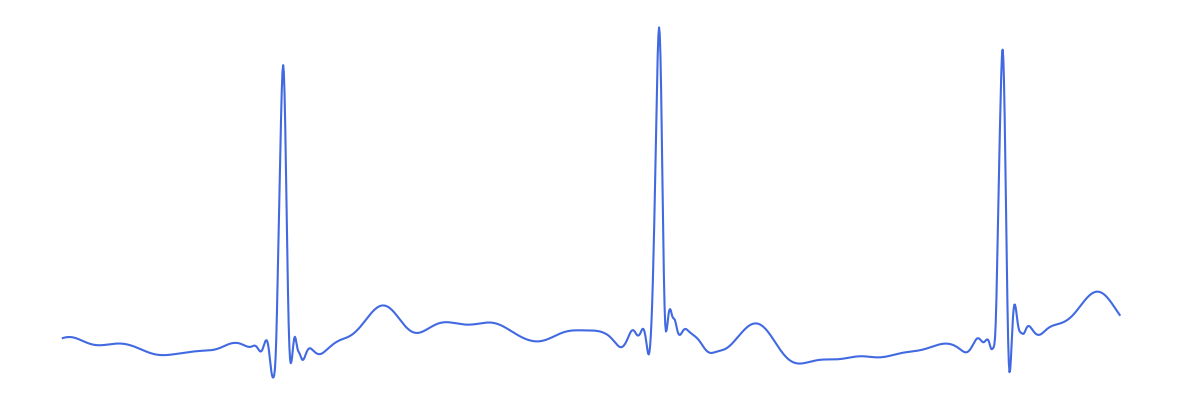

In [5]:
plt.figure(figsize=(15, 5))
plt.plot(df['ecg.ecg'][43][2000:3536], c='royalblue')
plt.axis('off')
plt.savefig('./results/sample_ecg.png', dpi=300)
#plt.close()

In [6]:
# Watch6,2 : Apple Watch Series 6 44mm case (GPS)
# Watch6,1 : Apple Watch Series 6 40mm case (GPS)
# Watch5,2 : Apple Watch Series 5 44mm case (GPS)

print('Watch Model:', df['apple_meta_data.hardware_version'].unique())

df['timestamp_recording'] = pd.to_datetime(df['apple_meta_data.recording_start_time'] + 978307200, unit='s')
df['subject'] = pd.factorize(df['device_id'])[0]

Watch Model: ['Watch6,2' 'Watch6,1' 'Watch5,2']


In [7]:
print('Total amount of ECG:', len(df))

Total amount of ECG: 509


In [8]:
df.groupby('subject')['subject'].count()

subject
0     50
1    240
2     16
3    203
Name: subject, dtype: int64

/var/folders/tb/_5frmyz16hz24t5gwc56dzmr0000gn/T/ipykernel_52990/1215283239.py:4: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.histplot(data=df, x="timestamp_recording", hue="subject", bins=100, palette=palette)


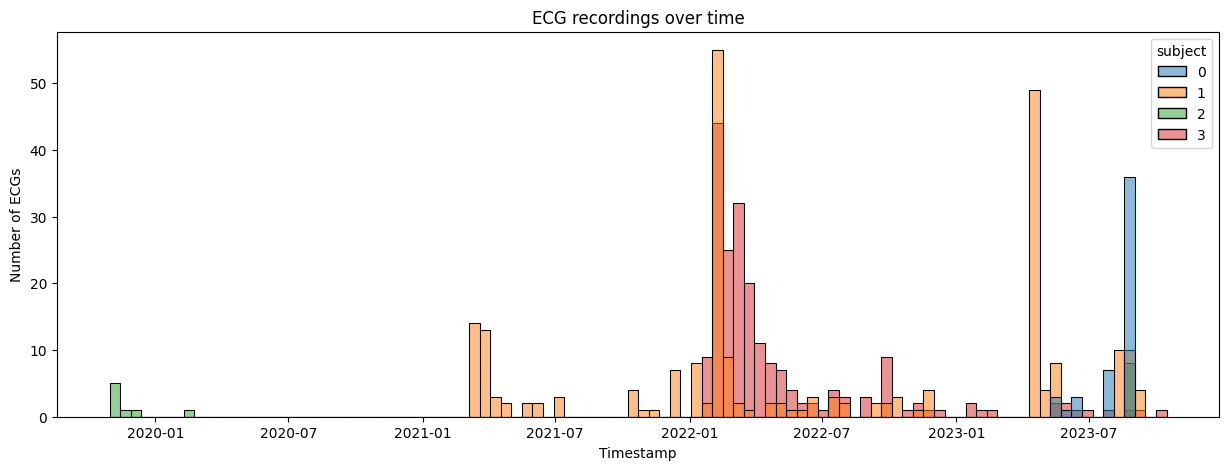

In [9]:
palette = sns.color_palette('tab10')
fig = plt.figure(figsize=(15,5))
plt.set_cmap('tab10')
ax = sns.histplot(data=df, x="timestamp_recording", hue="subject", bins=100, palette=palette)
ax.set(xlabel='Timestamp', ylabel='Number of ECGs')
ax.set_title('ECG recordings over time')
plt.show()
fig.savefig('./results/recordings.png', dpi=300)
plt.close()

### Functions and Tools for Evaluation

Mapping from PeakSwift's to NeuroKit's Algorithm Naming Convention

In [10]:
algorithm_conversion_peak = {
    'Christov': 'christov',
    'Two Average': 'elgendi',
    'NeuroKit': 'neurokit',
    'Hamilton': 'hamilton',
    'Pan Tompkins': 'pantompkins',
    'Kalidas': 'kalidas',
    'Engzee': 'engzee',
    'Nabian': 'nabian',
    'Basic': None,
    'Aristotle': None,
    'WQRS': None,
    'UNSW': None,
}

algorithm_conversion_clean = {
    'christov': 'christov',
    'elgendi': 'elgendi2010',
    'neurokit': 'neurokit',
    'hamilton': 'hamilton2002',
    'pantompkins': 'pantompkins1985',
    'engzee': 'engzeemod2012',
    'kalidas': 'kalidas',
    'nabian': 'nabian',
    'Basic': None,
    'Aristotle': None,
    'UNSW': None,
    'WQRS': None,
}

In [11]:
def closest_value(arr, value):
    """
    Find the value in an array 'arr' that is closest to the given 'value'.
    """
    return arr[np.argmin(np.abs(arr - value))]

def mapped_mae(arr1, arr2, threshold_low=0, threshold_up=1000000000):
    """
    Calculate the mapped Mean Absolute Error (MAE) between two arrays 'arr1' and 'arr2',
    with optional lower and upper thresholds for error calculation.
    """
    total_mae = 0
    
    shorter_arr = arr1 if len(arr1) < len(arr2) else arr2
    longer_arr = arr2 if len(arr1) < len(arr2) else arr1
    
    for val1 in shorter_arr:
        closest_val2 = closest_value(longer_arr, val1)
        abs_diff = np.abs(val1 - closest_val2)
        if threshold_low <= abs_diff <= threshold_up:
            total_mae += abs_diff
    
    if len(shorter_arr) == 0:
        return 0
    
    return total_mae / len(shorter_arr)

def mae(arr1, arr2, threshold_low=0, threshold_up=100000000000):
    """
    Calculate the Mean Absolute Error (MAE) between two arrays 'arr1' and 'arr2',
    with optional lower and upper thresholds for error calculation.
    """
    abs_diffs = np.abs(arr1 - arr2)
    abs_diffs[(abs_diffs <= threshold_low) | (abs_diffs >= threshold_up)] = 0
    return np.mean(abs_diffs)

In [12]:
def compare_algorithm(signal, method, result_swift, sampling_rate=512, index=None, plot=False):
    
    """
    Compare R-peak detection algorithms and visualize the results.

    Parameters:
    signal (array-like): ECG signal.
    method (str, optional): R-peak detection method (default: 'neurokit').
    result_swift (array-like): Detected R-peaks from Swift algorithm.
    sampling_rate (int, optional): Sampling rate of the signal (default: 512).
    index (int): Index of the signal.
    plot (bool): Whether to plot the comparison.

    Returns:
    dict: Dictionary containing comparison results.
    """

    start = time.time()
    if method != 'nabian':
        cleaned_signal = nk.ecg_clean(signal, sampling_rate, method=algorithm_conversion_clean[method])
    else:
        cleaned_signal = signal
    end = time.time()
    time_cleaning = (end - start)

    start = time.time()
    
    result_nk = nk.ecg_peaks(cleaned_signal, sampling_rate, method)
    end = time.time()
    time_rPeak_detection = (end - start)
    result_nk = np.where(result_nk[0]['ECG_R_Peaks'] > 0)[0]
    
    number_r_peaks_swift = len(result_swift)
    number_r_peaks_neurokit = len(result_nk)
    
    # Plot dedicated sample for the publication
    if (index == 118) & (method=='engzee'):
        n_peaks = 512*4
        plt.figure(figsize=(15, 5))
        plt.plot(signal[0:n_peaks], c='red', label='Original Signal')
        a = np.array(result_swift)
        b = np.array(result_nk)
        a = a[a <= n_peaks]
        b = b[b <= n_peaks]
        plt.vlines(
            x=a, colors='blue',
            ymin=0.0, ymax=np.max(signal),
            label='Swift: Detected ' + str(len(a)) +  ' R-peaks with ' + method,
        )
        plt.vlines(
            x=b, colors='green',
            ymin=np.min(signal), ymax=0.0,
            label='Python: Detected ' + str(len(b)) + ' R-peaks with ' + method,
        )
        plt.xlabel('Timestamp')
        plt.ylabel('Amplitude')
        plt.title('Comparison of R-peak Detection')
        plt.legend()
        plot_filename = f'./results/publication_sample_{index}_{method}.png'
        plt.savefig(plot_filename, dpi=300)
        plt.close()
    
    if plot & (number_r_peaks_swift !=number_r_peaks_neurokit):
        plt.figure(figsize=(60, 5))
        plt.plot(signal, c='red', label='Original Signal')
        plt.vlines(
            x=result_swift, colors='blue',
            ymin=np.min(signal), ymax=np.max(signal),
            label='Swift: Detected ' + str(len(result_swift)) +  ' R-peaks with ' + method,
        )
        plt.vlines(
            x=result_nk, colors='green',
            ymin=np.min(signal), ymax=np.max(signal),
            label='Python: Detected ' + str(len(result_nk)) + ' R-peaks with ' + method,
        )
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')
        plt.title('Comparison of R-peak Detection')
        plt.legend()
        plot_filename = f'./results/{index}_{method}.png'
        plt.savefig(plot_filename, dpi=300)
        plt.close()
    
    if (number_r_peaks_swift == number_r_peaks_neurokit):
        mean_difference_t0 = mae(result_nk, result_swift)
        mean_difference_t1 = mae(result_nk, result_swift, 1)
        mean_difference_t5 = mae(result_nk, result_swift, 5)
        mean_difference_t10 = mae(result_nk, result_swift, 200)
    else:
        mean_difference_t0 = np.nan
        mean_difference_t1 = np.nan
        mean_difference_t5 = np.nan
        mean_difference_t10 = np.nan

    mean_difference_mapped_t0 = mapped_mae(result_nk, result_swift)
    mean_difference_mapped_t1 = mapped_mae(result_nk, result_swift, 1)
    mean_difference_mapped_t5 = mapped_mae(result_nk, result_swift, 5)
    mean_difference_mapped_t10 = mapped_mae(result_nk, result_swift, 10)
    
    result = {
        'mean_difference_t0': mean_difference_t0,
        'mean_difference_t1': mean_difference_t1,
        'mean_difference_t5': mean_difference_t5,
        'mean_difference_t10': mean_difference_t10,
        'mean_difference_mapped_t0': mean_difference_mapped_t0,
        'mean_difference_mapped_t1': mean_difference_mapped_t1,
        'mean_difference_mapped_t5': mean_difference_mapped_t5,
        'mean_difference_mapped_t10': mean_difference_mapped_t10,
        'bpm_swift_simple': number_r_peaks_swift * 2,
        'bpm_swift_rr': (60*sampling_rate) / np.mean(np.diff(result_swift)),
        'number_r_peaks_swift': number_r_peaks_swift,
        'number_r_peaks_neurokit': number_r_peaks_neurokit,
        'runtime_m1_cleaning': time_cleaning,
        'runtime_m1_rPeak_detection': time_rPeak_detection,
    }
    
    return result

In [13]:
def process_row(row, algorithm_conversion_peak, index, plot=False):
    signal = np.array(row['ecg.ecg'])
    sampling_rate = row['ecg.sampling_rate']
    bpm_apple = row['apple_meta_data.beats_per_minute']
    
    quality_neurokit_simple = np.nan
    quality_peakswift_simple = np.nan
    quality_neurokit_fuzzy = np.nan
    quality_peakswift_fuzzy = np.nan
    
    for quality in row.signal_quality:
        if quality['method'] == 'Zhao2018Simple':
            quality_neurokit_simple = nk.ecg_quality(signal, method='zhao2018', approach='simple', sampling_rate=sampling_rate)
            quality_peakswift_simple = quality['score']
        elif quality['method'] == 'Zhao2018Fuzzy':
            quality_neurokit_fuzzy = nk.ecg_quality(signal, method='zhao2018', approach='fuzzy', sampling_rate=sampling_rate)
            quality_peakswift_fuzzy = quality['score']
        else:
            print('sth went wrong')
            
    quality_apple = row['apple_meta_data.apple_rating']
    
    result_rows = []
    
    identifier = row['device_id']
    device = row['apple_meta_data.hardware_version']
    subject = row['subject']
    
    for algo_info in row.algorithms:
        algo_name = algo_info['algorithm']
        algorithm = algorithm_conversion_peak.get(algo_name)
        
        if algorithm is None:
            continue
        
        try:
            comparison = compare_algorithm(signal, algorithm, algo_info['r_peaks'], sampling_rate, index, plot)
        except Exception as error:
            print('Exception', identifier, algorithm, error)
            continue

        metadata = {
            'id': index,
            'subject': subject,
            'device': device,
            'sampling_rate': sampling_rate,
            'signal_quality_neurokit_simple': quality_neurokit_simple,
            'signal_quality_neurokit_fuzzy': quality_neurokit_fuzzy,
            'signal_quality_swift_simple': quality_peakswift_simple,
            'signal_quality_swift_fuzzy': quality_peakswift_fuzzy,
            'signal_rating_apple': quality_apple,
            'algorithm': algorithm,
            'bpm_apple': bpm_apple,
            'runtime_swift': algo_info['runtime']['seconds'] + algo_info['runtime']['attoseconds'] / 1e+18
        }

        result_rows.append({**metadata, **comparison})

    return result_rows

Loop through the dataframe and construct a result table by gathering benchmarking metrics.

In [14]:
result_rows = []
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    result_rows.extend(process_row(row, algorithm_conversion_peak, index, False))
result_table = pd.DataFrame(result_rows)
result_table.index = range(len(result_table))

 12%|██████████████▉                                                                                                                  | 59/509 [00:11<01:28,  5.10it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 29%|████████████████████████████████████▉                                                                                           | 147/509 [00:29<01:10,  5.13it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 38%|████████████████████████████████████████████████                                                                                | 191/509 [00:38<01:02,  5.12it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar di

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 63%|████████████████████████████████████████████████████████████████████████████████▉                                               | 322/509 [01:04<00:36,  5.06it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 443/509 [01:28<00:13,  4.97it/s]

Exception 4AA362E7-E144-4221-B76F-0EB80FFA3DDF engzee pop from empty list


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 509/509 [01:41<00:00,  5.00it/s]


In [15]:
result_table['bpm_difference_simple'] = np.abs(result_table['bpm_apple'] - result_table['bpm_swift_simple'])
result_table['bpm_difference_rr'] = np.abs(result_table['bpm_apple'] - result_table['bpm_swift_rr'])
result_table['peak_diff'] = np.abs(result_table['number_r_peaks_neurokit'] - result_table['number_r_peaks_swift'])

runtime_m1_total = result_table['runtime_m1_cleaning'] + result_table['runtime_m1_rPeak_detection']
result_table['runtime_swift'] = result_table['runtime_swift'] * 1000 # ms instead of s
result_table['runtime_neurokit'] = runtime_m1_total * 1000 # ms instead of s
result_table['runtime_difference'] = result_table['runtime_neurokit'] - result_table['runtime_swift']

result_table['real_time_capabilities'] = result_table.runtime_swift / 30000.0
result_table['real_time_capabilities_bool'] = result_table.real_time_capabilities < 0.01

In [16]:
result_table.head(5)

,id,subject,device,sampling_rate,signal_quality_neurokit_simple,signal_quality_neurokit_fuzzy,signal_quality_swift_simple,signal_quality_swift_fuzzy,signal_rating_apple,algorithm,...,number_r_peaks_neurokit,runtime_m1_cleaning,runtime_m1_rPeak_detection,bpm_difference_simple,bpm_difference_rr,peak_diff,runtime_neurokit,runtime_difference,real_time_capabilities,real_time_capabilities_bool
0,0,0,"Watch6,2",512.0,Unacceptable,Barely acceptable,unacceptable,barelyAcceptable,Sinus rhytm,christov,...,44,0.000032,0.112122,4,4.275862,0,112.154007,109.050299,0.000103,True
1,0,0,"Watch6,2",512.0,Unacceptable,Barely acceptable,unacceptable,barelyAcceptable,Sinus rhytm,kalidas,...,43,0.000023,0.017645,2,2.349886,0,17.668009,16.246342,0.000047,True
2,0,0,"Watch6,2",512.0,Unacceptable,Barely acceptable,unacceptable,barelyAcceptable,Sinus rhytm,elgendi,...,43,0.000561,0.005697,2,2.044682,0,6.258011,5.665720,0.000020,True
3,0,0,"Watch6,2",512.0,Unacceptable,Barely acceptable,unacceptable,barelyAcceptable,Sinus rhytm,nabian,...,43,0.000000,0.015528,2,2.896552,0,15.527964,6.102547,0.000314,True
4,0,0,"Watch6,2",512.0,Unacceptable,Barely acceptable,unacceptable,barelyAcceptable,Sinus rhytm,hamilton,...,44,0.000357,0.005534,4,4.293563,0,5.891085,5.546627,0.000011,True


### Signal Quality

In [17]:
def plot_confusion_matrix(
    groundtruth, prediction, labels,
    title, xlabel='PeakSwift', ylabel='NeuroKit', x_rotation=0, y_rotation=0,
    save=False
):
    cm = confusion_matrix(groundtruth, prediction, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    disp.ax_.set(title=title, xlabel = xlabel, ylabel = ylabel)
    plt.xticks(rotation=x_rotation)
    plt.yticks(rotation=y_rotation)
    if save:
        plt.savefig('./results/' + title + '.png', dpi=300)
    plt.show()
    plt.close()

In [18]:
sq = result_table[
    [
        'id', 'signal_quality_neurokit_simple',
        'signal_quality_neurokit_fuzzy', 'signal_quality_swift_simple',
        'signal_quality_swift_fuzzy', 'signal_rating_apple',
    ]
].drop_duplicates('id')

In [19]:
labels = ['Excellent', 'Barely acceptable', 'Unacceptable']
labels_apple = list(sq.signal_rating_apple.unique())

In [20]:
# Neurokit returns a small spelling mistake: Unnacceptable
sq.signal_quality_neurokit_fuzzy = sq.signal_quality_neurokit_fuzzy.replace('Unnacceptable', 'Unacceptable')

In [21]:
sq.signal_quality_swift_simple = sq.signal_quality_swift_simple.replace('barelyAcceptable', 'Barely acceptable').replace('unacceptable', 'Unacceptable').replace('excellent', 'Excellent')
sq.signal_quality_swift_fuzzy = sq.signal_quality_swift_fuzzy.replace('barelyAcceptable', 'Barely acceptable').replace('unacceptable', 'Unacceptable').replace('excellent', 'Excellent')

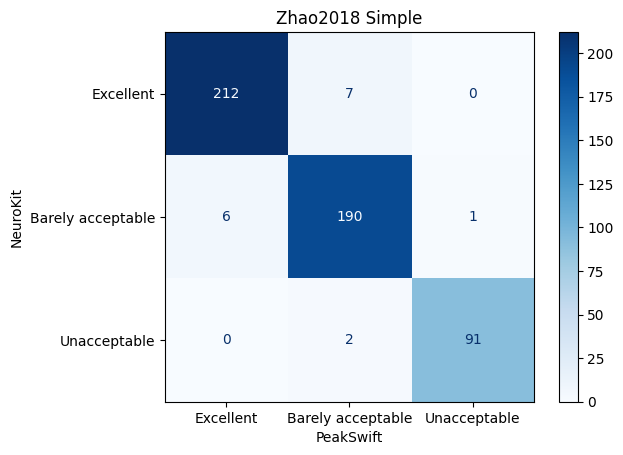

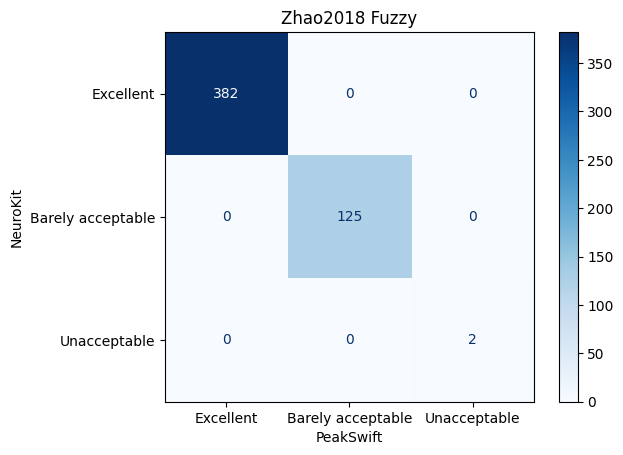

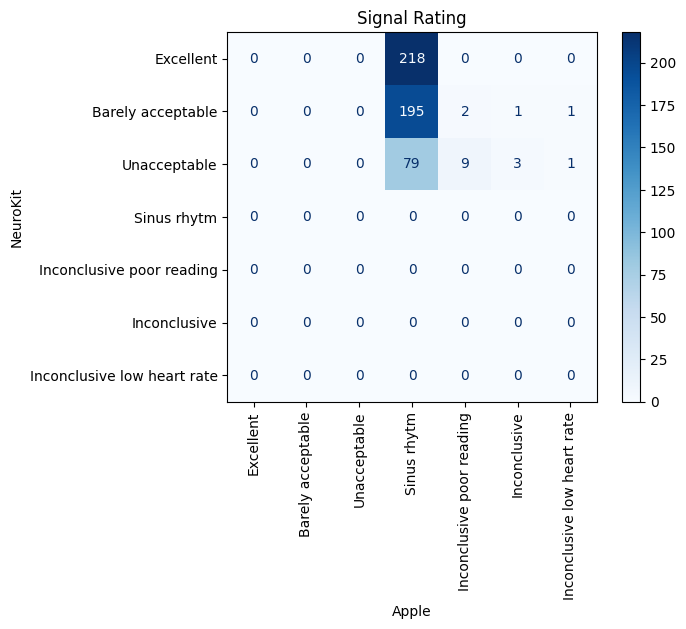

In [22]:
plot_confusion_matrix(
    sq.signal_quality_neurokit_simple, sq.signal_quality_swift_simple, labels,
    title="Zhao2018 Simple", y_rotation=0, save=True,
)
plot_confusion_matrix(
    sq.signal_quality_neurokit_fuzzy, sq.signal_quality_swift_fuzzy, labels,
    title="Zhao2018 Fuzzy", y_rotation=0, save=True,
)
plot_confusion_matrix(
    sq.signal_quality_swift_simple, sq.signal_rating_apple, labels + labels_apple,
    title="Signal Rating", xlabel='Apple', x_rotation=90, save=True,
)

### R-peak Detection Accuracy

In [23]:
print(
    'Mean Absolute Error:',
    np.mean(result_table.mean_difference_t0),
    '±',
    np.std(result_table.mean_difference_t0),
)

Mean Absolute Error: 0.003171951840883707 ± 0.08071190684109533


In [24]:
print(
    'Mean Absolute Error (error tolerance 10):',
    np.mean(result_table.mean_difference_t10),
    '±',
    np.std(result_table.mean_difference_t10),
)

Mean Absolute Error (error tolerance 10): 0.0 ± 0.0


In [25]:
print(
    'Number of deviating R-peak count:',
    len(result_table[result_table.peak_diff != 0]),
)
print(
    'Mean Absolute Error:',
    np.mean(result_table.mean_difference_mapped_t0),
    '±',
    np.std(result_table.mean_difference_mapped_t0),
)

print(
    'Mean Absolute Error (error tolerance 10):',
    np.mean(result_table.mean_difference_mapped_t10),
    '±',
    np.std(result_table.mean_difference_mapped_t10),
)

Number of deviating R-peak count: 15
Mean Absolute Error: 0.003470396053621924 ± 0.0829487372539662
Mean Absolute Error (error tolerance 10): 0.0031881682528231226 ± 0.08291181533469877


In [26]:
print(
    'Difference to Apple BPM (simple):',
    np.mean(result_table.bpm_difference_simple),
    '±',
    np.std(result_table.bpm_difference_simple),
)

print(
    'Difference to Apple BPM (RR):',
    np.mean(result_table.bpm_difference_rr),
    '±',
    np.std(result_table.bpm_difference_rr),
)

print(
    'BPM Difference without Christov (simple):',
    np.mean(result_table[result_table.algorithm != 'christov'].bpm_difference_simple),
    '±',
    np.std(result_table[result_table.algorithm != 'christov'].bpm_difference_simple),
)

print(
    'BPM Difference without Christov (rr):',
    np.mean(result_table[result_table.algorithm != 'christov'].bpm_difference_rr),
    '±',
    np.std(result_table[result_table.algorithm != 'christov'].bpm_difference_rr),
)

Difference to Apple BPM (simple): 9.029245514868519 ± 32.11564229722207
Difference to Apple BPM (RR): 8.58593310479604 ± 33.26413299569645
BPM Difference without Christov (simple): 3.398876404494382 ± 10.922577322534577
BPM Difference without Christov (rr): 2.688436028318112 ± 11.128866454892181


In [27]:
print(
    'Runtime Difference (ms):',
    np.mean(result_table.runtime_difference),
    '±',
    np.std(result_table.runtime_difference),
)
print(
    'Runtime Difference without Christov (ms):',
    np.mean(result_table[result_table.algorithm != 'christov'].runtime_difference),
    '±',
    np.std(result_table[result_table.algorithm != 'christov'].runtime_difference),
)

Runtime Difference (ms): 20.051046053343107 ± 34.59314267302072
Runtime Difference without Christov (ms): 8.122799434786712 ± 14.921451485201388


In [28]:
def mean_std(series):
    return str(np.round(np.mean(series),2)) + '$\pm$' + str(np.round(np.std(series),2))

In [29]:
evaluation_overview = result_table.groupby('algorithm')[
    [
        'mean_difference_t0', 'mean_difference_mapped_t0',
        'peak_diff', 'runtime_neurokit', 'runtime_swift', 'runtime_difference',
        'bpm_difference_rr', 'real_time_capabilities',
    ]
].agg(mean_std)

In [30]:
evaluation_overview

,mean_difference_t0,mean_difference_mapped_t0,peak_diff,runtime_neurokit,runtime_swift,runtime_difference,bpm_difference_rr,real_time_capabilities
algorithm,,,,,,,,
christov,0.0$\pm$0.0,0.0$\pm$0.0,0.0$\pm$0.0,108.79$\pm$6.91,5.31$\pm$2.18,103.48$\pm$7.34,49.89$\pm$77.71,0.0$\pm$0.0
elgendi,0.02$\pm$0.2,0.02$\pm$0.2,0.0$\pm$0.04,6.14$\pm$0.28,0.77$\pm$0.72,5.37$\pm$0.77,2.79$\pm$12.31,0.0$\pm$0.0
engzee,0.0$\pm$0.0,0.0$\pm$0.0,0.0$\pm$0.06,45.27$\pm$1.58,1.18$\pm$0.66,44.09$\pm$1.69,2.88$\pm$10.57,0.0$\pm$0.0
hamilton,0.0$\pm$0.0,0.0$\pm$0.06,0.0$\pm$0.04,5.87$\pm$0.26,0.51$\pm$0.33,5.36$\pm$0.42,2.62$\pm$10.79,0.0$\pm$0.0
kalidas,0.0$\pm$0.0,0.0$\pm$0.0,0.0$\pm$0.0,1.18$\pm$0.74,1.6$\pm$0.9,-0.42$\pm$1.17,2.36$\pm$10.65,0.0$\pm$0.0
nabian,0.0$\pm$0.0,0.0$\pm$0.0,0.0$\pm$0.0,15.79$\pm$0.41,13.91$\pm$4.39,1.88$\pm$4.37,3.24$\pm$11.31,0.0$\pm$0.0
neurokit,0.01$\pm$0.1,0.01$\pm$0.1,0.02$\pm$0.16,1.73$\pm$0.21,1.11$\pm$0.75,0.61$\pm$0.79,2.26$\pm$10.58,0.0$\pm$0.0
pantompkins,0.0$\pm$0.0,0.0$\pm$0.0,0.0$\pm$0.0,0.84$\pm$0.09,0.66$\pm$0.42,0.18$\pm$0.42,2.67$\pm$11.54,0.0$\pm$0.0


In [31]:
result_table.groupby('algorithm')[['peak_diff']].agg(np.sum)

,peak_diff
algorithm,
christov,0
elgendi,1
engzee,2
hamilton,1
kalidas,0
nabian,0
neurokit,12
pantompkins,0


In [32]:
evaluation_overview.to_latex().replace('\n', '')

/var/folders/tb/_5frmyz16hz24t5gwc56dzmr0000gn/T/ipykernel_52990/1442046673.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  evaluation_overview.to_latex().replace('\n', '')


'\\begin{tabular}{lllllllll}\\toprule{} & mean\\_difference\\_t0 & mean\\_difference\\_mapped\\_t0 &      peak\\_diff & runtime\\_neurokit &   runtime\\_swift & runtime\\_difference & bpm\\_difference\\_rr & real\\_time\\_capabilities \\\\algorithm   &                    &                           &                &                  &                 &                    &                   &                        \\\\\\midrulechristov    &        0.0\\$\\textbackslash pm\\$0.0 &               0.0\\$\\textbackslash pm\\$0.0 &    0.0\\$\\textbackslash pm\\$0.0 &  108.79\\$\\textbackslash pm\\$6.91 &   5.31\\$\\textbackslash pm\\$2.18 &    103.48\\$\\textbackslash pm\\$7.34 &   49.89\\$\\textbackslash pm\\$77.71 &            0.0\\$\\textbackslash pm\\$0.0 \\\\elgendi     &       0.02\\$\\textbackslash pm\\$0.2 &              0.02\\$\\textbackslash pm\\$0.2 &   0.0\\$\\textbackslash pm\\$0.04 &    6.14\\$\\textbackslash pm\\$0.28 &   0.77\\$\\textbackslash pm\\$0.72 &      5.37\\$\\text

In [33]:
rt_overview = result_table.groupby('subject')[
    [
        'mean_difference_t0', 'mean_difference_mapped_t0',
        'peak_diff', 'bpm_difference_rr', 'runtime_difference',
    ]
].agg(mean_std)

In [34]:
rt_overview

,mean_difference_t0,mean_difference_mapped_t0,peak_diff,bpm_difference_rr,runtime_difference
subject,,,,,
0,0.01$\pm$0.11,0.01$\pm$0.11,0.0$\pm$0.05,11.76$\pm$35.74,19.56$\pm$33.71
1,0.0$\pm$0.09,0.0$\pm$0.09,0.0$\pm$0.06,7.67$\pm$30.05,19.78$\pm$34.35
2,0.0$\pm$0.0,0.0$\pm$0.0,0.0$\pm$0.0,7.06$\pm$20.01,20.99$\pm$35.65
3,0.0$\pm$0.06,0.0$\pm$0.07,0.01$\pm$0.08,9.0$\pm$36.84,20.42$\pm$35.01


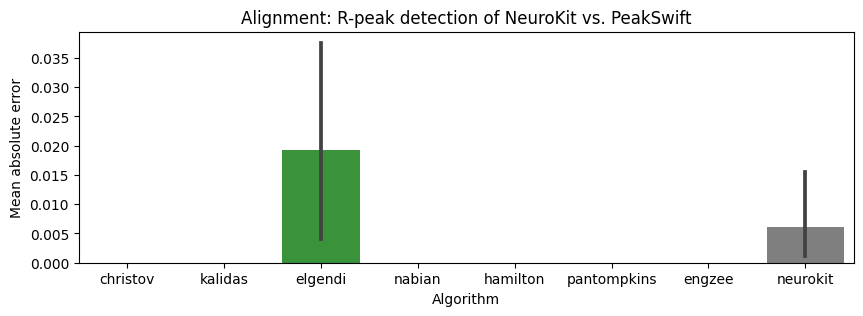

In [35]:
fig = plt.figure(figsize=(10,3))
ax = sns.barplot(data=result_table, x="algorithm", y="mean_difference_t0")
ax.set(xlabel='Algorithm', ylabel='Mean absolute error')
ax.set_title('Alignment: R-peak detection of NeuroKit vs. PeakSwift')
plt.show()
fig.savefig('./results/comparisonRPeak.png', dpi=300)
plt.close()

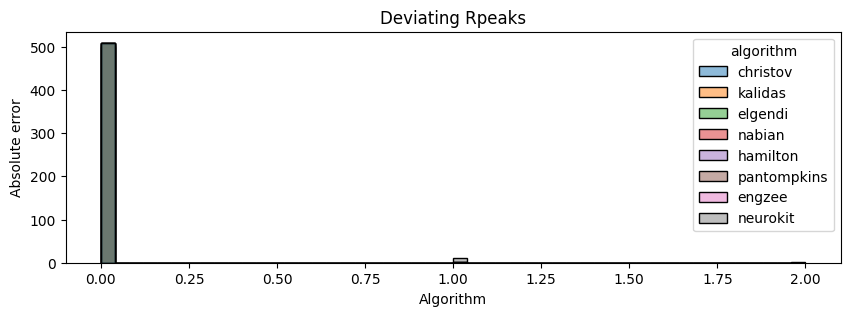

In [36]:
fig = plt.figure(figsize=(10,3))
ax = sns.histplot(data=result_table, x="peak_diff", hue="algorithm", bins=50)
ax.set(xlabel='Algorithm', ylabel='Absolute error')
ax.set_title('Deviating Rpeaks')
plt.show()
fig.savefig('./results/deviations_number_rpeaks.png', dpi=300)
plt.close()

### Beats per Minute Accuracy
Assessed in a comparison towards FDA approved Apple's BPM rating.

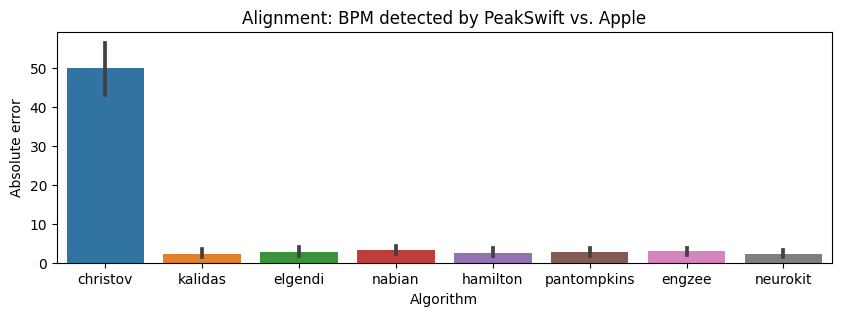

In [37]:
fig = plt.figure(figsize=(10,3))
ax = sns.barplot(data=result_table, x="algorithm", y="bpm_difference_rr")
ax.set(xlabel='Algorithm', ylabel='Absolute error')
ax.set_title('Alignment: BPM detected by PeakSwift vs. Apple')
plt.show()
fig.savefig('./results/comparisonBPM.png', dpi=300)
plt.close()

### Computational Runtime

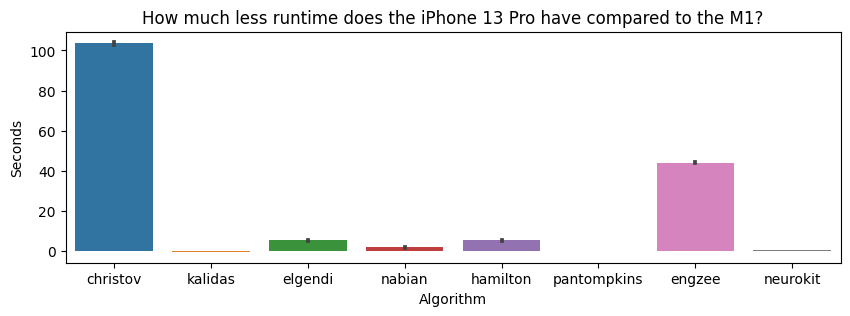

In [38]:
fig = plt.figure(figsize=(10,3))
ax = sns.barplot(data=result_table, x="algorithm", y="runtime_difference")
ax.set(xlabel='Algorithm', ylabel='Seconds')
ax.set_title('How much less runtime does the iPhone 13 Pro have compared to the M1?')
plt.show()
fig.savefig('./results/comparisonRuntime.png', dpi=300)
plt.close()

### Real-Time Capabilities

In [39]:
result_table.groupby(['algorithm', 'real_time_capabilities_bool'])['id'].count()

algorithm    real_time_capabilities_bool
christov     True                           509
elgendi      True                           509
engzee       True                           506
hamilton     True                           509
kalidas      True                           509
nabian       True                           509
neurokit     True                           509
pantompkins  True                           509
Name: id, dtype: int64